# Football Match Prediction - Multi-Output Neural Network

This notebook implements a **single multi-output neural network** that predicts football match scores using **probability distributions**.

## Key Features:
- Single model with **two output heads** (home & away goals)
- Outputs **probability distributions** over possible goals (0-10)
- Uses **softmax activation** for probabilistic predictions
- Saves processed data and model weights
- Loads saved model for inference

---

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import ast
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

2025-12-13 18:20:13.812004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-13 18:20:13.812213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-13 18:20:13.888396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-13 18:20:14.041070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-13 18:20:16.237235: W tensorflow/compiler/tf2

✅ Libraries imported successfully!


## 2. Configuration

In [3]:
# Model configuration
MAX_GOALS = 9  # Maximum goals to predict (0-10)
NUM_CLASSES = MAX_GOALS + 1  # 11 classes (0, 1, 2, ..., 10)

print(f"Configuration:")
print(f"  Max goals per team: {MAX_GOALS}")
print(f"  Number of classes: {NUM_CLASSES}")

Configuration:
  Max goals per team: 9
  Number of classes: 10


## 3. Helper Functions

### 3.1 Player Data Parsing

In [ ]:
def parse_player_data(player_str):
    """Parse the string representation of player data"""
    try:
        data = ast.literal_eval(player_str)
        return data if isinstance(data, list) else []
    except:
        return []


✅ Player parsing functions defined


In [ ]:
def extract_player_stats(player_dict, is_goalkeeper=False):
    """
    Extract relevant stats from a player dict.
    Only includes stats used for model training.

    Args:
        player_dict: Dictionary containing player data
        is_goalkeeper: Boolean indicating if this is a goalkeeper

    Returns:
        Dictionary with only the relevant stats
    """
    stats = {}

    # Define allowed stats based on player type
    if is_goalkeeper:
        # Goalkeeper stats from the image
        allowed_stats = [
            # Shot Stopping
            'SoTA', 'GA', 'Saves', 'Save%', 'PSxG',
            # Launched
            'Cmp', 'Att', 'Cmp%',
            # Passes
            'Att_(GK)', 'Launch%', 'AvgLen','Thr',
            'Opp', 'Stp', 'Stp%', '#OPA', 'AvgDist',

        ]
    else:
        # Outfield player stats from the image
        allowed_stats = [
            # Performance
            'Gls', 'Ast', 'Sh', 'SoT',
            'Touches', 'Tkl', 'Int', 'Blocks',
            # Expected
            'xG', 'npxG', 'xAG',
            # SCA
            'SCA', 'GCA',
            # Passes
            'Cmp', 'Att', 'Cmp%', 'PrgP',
            # Carries
            'Carries', 'PrgC',
            # Take-Ons
            'Att', 'Succ'
        ]

    # Convert allowed_stats to lowercase for case-insensitive matching
    allowed_stats_lower = {stat.lower() for stat in allowed_stats}

    for key, value in player_dict.items():
        # Handle tuple keys (e.g., ('Performance', 'Gls'))
        if isinstance(key, tuple):
            # Get the LAST non-empty element (the actual stat name)
            stat_parts = [str(k) for k in key if k != '']
            if not stat_parts:
                continue
            stat_name_base = stat_parts[-1]  # ← Take only the last part
            stat_name = '_'.join(stat_parts).replace(' ', '_')
        else:
            stat_name_base = str(key)
            stat_name = str(key)

        # Check if the BASE stat name (without category prefix) is allowed
        if stat_name_base.lower() in allowed_stats_lower:
            try:
                stats[stat_name] = float(value) if value not in [None, '', 'None'] else 0.0
            except:
                pass

    return stats


print(" Player parsing functions defined")


✅ Player parsing functions defined


### 3.2 Optimized Rolling Window Functions 

In [ ]:
def process_match_rolling(row, player_history, gk_history):
    team = row['team']
    league = row['league']
    season = row['season']

    outfield_players = parse_player_data(row['outfield_players'])
    goalkeepers = parse_player_data(row['keepers'])

    outfield_stats_list = []

    for player in outfield_players:
        playername = player.get(('player', ''), '') or player.get('player', '')
        if not playername:
            continue

        key = (playername, team, league, season)

        if key in player_history and len(player_history[key]) > 0:
            all_stat_keys = set()
            for game_stats in player_history[key]:
                all_stat_keys.update(game_stats.keys())

            avg_stats = {}
            for stat_key in all_stat_keys:
                values = [g.get(stat_key, 0) for g in player_history[key]]
                avg_stats[stat_key] = np.mean(values)

            outfield_stats_list.append(avg_stats)
        else:
            stats = extract_player_stats(player, is_goalkeeper=False)
            if stats:
                outfield_stats_list.append(stats)

        #  STOP at 15 players
        if len(outfield_stats_list) >= 15:
            break

    # Handle case with stats aggregation
    if len(outfield_stats_list) > 0:
        #  Cap to 15 maximum
        outfield_stats_list = outfield_stats_list[:15]

        all_keys = set()
        for stats in outfield_stats_list:
            all_keys.update(stats.keys())

        avg_aggregated_stats = {}
        for key in all_keys:
            values = [s.get(key, 0) for s in outfield_stats_list]
            avg_aggregated_stats[key] = np.mean(values)

        # Pad if less than 15
        while len(outfield_stats_list) < 15:
            outfield_stats_list.append(avg_aggregated_stats.copy())
    else:
        outfield_stats_list = [{} for _ in range(15)]

    gk_stats = {}
    if goalkeepers:
        gk_with_minutes = []
        for gk in goalkeepers:
            minutes = gk.get(('min', ''), 0)
            try:
                minutes = float(minutes)
            except:
                minutes = 0
            gk_name = gk.get(('player', ''), '')
            gk_with_minutes.append((gk, gk_name, minutes))

        gk_with_minutes.sort(key=lambda x: x[2], reverse=True)
        main_gk_data, main_gk_name, _ = gk_with_minutes[0]

        key = (main_gk_name, team, league, season)

        if key in gk_history and len(gk_history[key]) > 0:
            all_stat_keys = set()
            for game_stats in gk_history[key]:
                all_stat_keys.update(game_stats.keys())

            gk_stats = {}
            for stat_key in all_stat_keys:
                values = [g.get(stat_key, 0) for g in gk_history[key]]
                gk_stats[stat_key] = np.mean(values)
        else:
            gk_stats = extract_player_stats(main_gk_data, is_goalkeeper=True)

    team_features = {
        'xg_for': row['xg_for'],
        'xg_against': row['xg_against'],
        'is_home': row['is_home'],
        'club_ranking': row['club_ranking'] if pd.notna(row['club_ranking']) else 10,
        'avg_goals_for_last5': row['avg_goals_for_last5'],
        'avg_goals_against_last5': row['avg_goals_against_last5'],
        'avg_points_last5': row['avg_points_last5'],
        'recent_form_score_last5': row['recent_form_score_last5']
    }

    return {
        'team_features': team_features,
        'outfield_stats': outfield_stats_list,
        'gk_stats': gk_stats,
        'goals': row['goals_for']
    }


def update_player_history(row, player_history, gk_history):
    """Update rolling history with stats from this match"""
    team = row['team']
    league = row['league']
    season = row['season']

    outfield_players = parse_player_data(row['outfield_players'])
    for player in outfield_players:
        player_name = player.get(('player', ''), '')
        if not player_name:
            continue

        key = (player_name, team, league, season)
        stats = extract_player_stats(player, is_goalkeeper=False)

        if stats:
            if key not in player_history:
                player_history[key] = []
            player_history[key].append(stats)

    goalkeepers = parse_player_data(row['keepers'])
    for gk in goalkeepers:
        gk_name = gk.get(('player', ''), '')
        if not gk_name:
            continue

        key = (gk_name, team, league, season)
        stats = extract_player_stats(gk, is_goalkeeper=True)

        if stats:
            if key not in gk_history:
                gk_history[key] = []
            gk_history[key].append(stats)

print(" Rolling window functions defined")

✅ Rolling window functions defined


### 3.3 Match-Level Feature Creation

In [ ]:
def create_match_level_features(home_data, away_data):
    """Combine home and away team data into match-level features"""
    features = {}

    for key, value in home_data['team_features'].items():
        features[f'home_{key}'] = value

    for key, value in away_data['team_features'].items():
        features[f'away_{key}'] = value

    features['rank_diff'] = home_data['team_features']['club_ranking'] - away_data['team_features']['club_ranking']
    features['avg_points_diff'] = home_data['team_features']['avg_points_last5'] - away_data['team_features']['avg_points_last5']
    features['form_diff'] = home_data['team_features']['recent_form_score_last5'] - away_data['team_features']['recent_form_score_last5']

    for i, player_stats in enumerate(home_data['outfield_stats']):
        for stat_name, stat_value in player_stats.items():
            features[f'home_player{i+1}_{stat_name}'] = stat_value

    for i, player_stats in enumerate(away_data['outfield_stats']):
        for stat_name, stat_value in player_stats.items():
            features[f'away_player{i+1}_{stat_name}'] = stat_value

    for stat_name, stat_value in home_data['gk_stats'].items():
        features[f'home_gk_{stat_name}'] = stat_value

    for stat_name, stat_value in away_data['gk_stats'].items():
        features[f'away_gk_{stat_name}'] = stat_value

    targets = {
        'home_goals': home_data['goals'],
        'away_goals': away_data['goals']
    }

        # 1. Attack vs Defense matchup
    features['home_attack_vs_away_defense'] = (
        home_data['team_features']['xg_for'] -
        away_data['team_features']['xg_against']
    )
    features['away_attack_vs_home_defense'] = (
        away_data['team_features']['xg_for'] -
        home_data['team_features']['xg_against']
    )

    # 2. Total expected goals (high-scoring match indicator)
    features['expected_total_goals'] = (
        home_data['team_features']['xg_for'] +
        away_data['team_features']['xg_for']
    )

    # 3. Team quality ratio
    features['team_quality_ratio'] = (
        home_data['team_features']['avg_points_last5'] /
        (away_data['team_features']['avg_points_last5'] + 0.1)
    )

    # 4. High-scoring team indicator
    features['home_high_scorer'] = int(
        home_data['team_features']['avg_goals_for_last5'] > 2.0
    )
    features['away_high_scorer'] = int(
        away_data['team_features']['avg_goals_for_last5'] > 2.0
    )

    # 5. Defensive strength indicator
    features['home_defensive'] = int(
        home_data['team_features']['avg_goals_against_last5'] < 1.0
    )
    features['away_defensive'] = int(
        away_data['team_features']['avg_goals_against_last5'] < 1.0
    )

    # 6. Ranking difference (squared to emphasize large gaps)
    rank_diff = home_data['team_features']['club_ranking'] - away_data['team_features']['club_ranking']
    features['rank_diff_squared'] = rank_diff ** 2
    features['rank_diff_abs'] = abs(rank_diff)

    # 7. Form momentum
    features['home_form_momentum'] = (
        home_data['team_features']['recent_form_score_last5'] / 10.0
    )
    features['away_form_momentum'] = (
        away_data['team_features']['recent_form_score_last5'] / 10.0
    )

    # 8. Likely mismatch indicator
    features['likely_mismatch'] = int(
        abs(rank_diff) > 10 or
        abs(features['team_quality_ratio'] - 1.0) > 1.5
    )

    return features, targets

print(" Feature creation function defined")

✅ Feature creation function defined


### 3.4 Dataset Preparation

In [ ]:
def prepare_dataset(csv_file):
    """Optimized dataset preparation with rolling window"""
    print(f"Loading data from {csv_file}...")

    df = pd.read_csv(csv_file, engine='python', encoding='utf-8')
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['league', 'season', 'date', 'match_id'])

    print(f"Total rows: {len(df)}")

    player_history = {}
    gk_history = {}

    print("Processing matches with optimized rolling window approach...")

    match_groups = list(df.groupby('match_id'))
    matches = []

    for match_idx, (match_id, match_rows) in enumerate(match_groups):
        if len(match_rows) != 2:
            continue

        home_row = match_rows[match_rows['is_home'] == 1]
        away_row = match_rows[match_rows['is_home'] == 0]

        if len(home_row) != 1 or len(away_row) != 1:
            home_row = match_rows.iloc[0:1]
            away_row = match_rows.iloc[1:2]

        home_row = home_row.iloc[0]
        away_row = away_row.iloc[0]

        home_data = process_match_rolling(home_row, player_history, gk_history)
        away_data = process_match_rolling(away_row, player_history, gk_history)

        update_player_history(home_row, player_history, gk_history)
        update_player_history(away_row, player_history, gk_history)

        features, targets = create_match_level_features(home_data, away_data)

        match_record = {
            'match_id': match_id,
            'date': home_row['date'],
            'league': home_row['league'],
            'season': home_row['season'],
            'home_team': home_row['team'],
            'away_team': away_row['team'],
            **features,
            **targets
        }

        matches.append(match_record)

        if len(matches) % 100 == 0:
            print(f"  Processed {len(matches)} matches... ⚡")

    print(f"Total matches processed: {len(matches)}")

    df_matches = pd.DataFrame(matches)
    return df_matches

print("✅ Dataset preparation function defined")

✅ Dataset preparation function defined


## 4. Load and Prepare Data

In [23]:
# Input your CSV file path
csv_file = "processed_football_data.csv"

# Process the dataset
df_matches = prepare_dataset(csv_file)

Loading data from processed_football_data.csv...
Total rows: 30114
Processing matches with optimized rolling window approach...
  Processed 100 matches... ⚡
  Processed 200 matches... ⚡
  Processed 300 matches... ⚡
  Processed 400 matches... ⚡
  Processed 500 matches... ⚡
  Processed 600 matches... ⚡
  Processed 700 matches... ⚡
  Processed 800 matches... ⚡
  Processed 900 matches... ⚡
  Processed 1000 matches... ⚡
  Processed 1100 matches... ⚡
  Processed 1200 matches... ⚡
  Processed 1300 matches... ⚡
  Processed 1400 matches... ⚡
  Processed 1500 matches... ⚡
  Processed 1600 matches... ⚡
  Processed 1700 matches... ⚡
  Processed 1800 matches... ⚡
  Processed 1900 matches... ⚡
  Processed 2000 matches... ⚡
  Processed 2100 matches... ⚡
  Processed 2200 matches... ⚡
  Processed 2300 matches... ⚡
  Processed 2400 matches... ⚡
  Processed 2500 matches... ⚡
  Processed 2600 matches... ⚡
  Processed 2700 matches... ⚡
  Processed 2800 matches... ⚡
  Processed 2900 matches... ⚡
  Processed

## 5. Save Processed Data 

In [ ]:
# Save processed data
output_file = 'inference_csv.csv'
df_matches.to_csv(output_file, index=False)

print(f"\n{'='*60}")
print("PROCESSED DATA SAVED")
print(f"{'='*60}")
print(f"File: {output_file}")
print(f"Rows: {len(df_matches)}")
print(f"Columns: {len(df_matches.columns)}")


✅ PROCESSED DATA SAVED
File: inference_csv.csv
Rows: 15057
Columns: 678


## 6. Prepare Features and Targets

In [9]:
# Separate features and targets
feature_cols = [col for col in df_matches.columns if col not in
               ['match_id', 'date', 'league', 'season', 'home_team', 'away_team', 'home_goals', 'away_goals']]

X = df_matches[feature_cols].fillna(0)
y_home = df_matches['home_goals'].values
y_away = df_matches['away_goals'].values

# Clip goals to MAX_GOALS (e.g., 8 goals becomes 10 if MAX_GOALS=10)
y_home = np.clip(y_home, 0, MAX_GOALS)
y_away = np.clip(y_away, 0, MAX_GOALS)

# Convert to categorical (one-hot encoding)
y_home_cat = to_categorical(y_home, num_classes=NUM_CLASSES)
y_away_cat = to_categorical(y_away, num_classes=NUM_CLASSES)

print(f"Features: {len(feature_cols)} columns")
print(f"Samples: {len(X)} matches")
print(f"Home goals shape: {y_home_cat.shape}")
print(f"Away goals shape: {y_away_cat.shape}")
print(f"\nGoal distribution:")
print(f"  Home: {np.bincount(y_home.astype(int))}")
print(f"  Away: {np.bincount(y_away.astype(int))}")

Features: 1062 columns
Samples: 15057 matches
Home goals shape: (15057, 10)
Away goals shape: (15057, 10)

Goal distribution:
  Home: [3440 4930 3653 1846  763  298   90   24   10    3]
  Away: [4525 5254 3204 1370  495  154   44    9    1    1]


## 7. Split and Scale Data

In [10]:
# Split data
X_temp, X_test, y_home_temp, y_home_test, y_away_temp, y_away_test = train_test_split(
    X, y_home_cat, y_away_cat, test_size=0.07, random_state=42
)
"""
X_train, X_val, y_home_train, y_home_val, y_away_train, y_away_val = train_test_split(
    X_temp, y_home_temp, y_away_temp, test_size=0.0, random_state=42
)"""
X_train, X_val, y_home_train, y_home_val, y_away_train, y_away_val = X_temp, X_test, y_home_temp, y_home_test, y_away_temp, y_away_test
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
#X_test_scaled = scaler.transform(X_test)

print(f"\n{'='*60}")
print("DATASET SPLIT")
print(f"{'='*60}")
print(f"Training:   {len(X_train)} matches ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation: {len(X_val)} matches ({len(X_val)/len(X)*100:.1f}%)")
#print(f"Test:       {len(X_test)} matches ({len(X_test)/len(X)*100:.1f}%)")


DATASET SPLIT
Training:   14003 matches (93.0%)
Validation: 1054 matches (7.0%)


## 8. Build Multi-Output Neural Network 

### Architecture:
- **Shared layers**: Process input features
- **Two output heads**:
  - Home goals: Softmax over 11 classes (0-10 goals)
  - Away goals: Softmax over 11 classes (0-10 goals)

In [11]:
def build_multioutput_model(input_dim, num_classes):
    """
    Build multi-output neural network with probability distributions

    Returns:
    --------
    model : keras.Model
        Model with two outputs (home_goals, away_goals)
    """
    # Input layer
    inputs = layers.Input(shape=(input_dim,), name='input')

    # Shared layers (feature extraction)
    x = layers.Dense(512, activation='relu', name='shared_1')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation='relu', name='shared_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu', name='shared_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Home goals head
    home_branch = layers.Dense(64, activation='relu', name='home_dense')(x)
    home_branch = layers.Dropout(0.2)(home_branch)
    home_output = layers.Dense(
        num_classes,
        activation='softmax',  # Probability distribution
        name='home_goals'
    )(home_branch)

    # Away goals head
    away_branch = layers.Dense(64, activation='relu', name='away_dense')(x)
    away_branch = layers.Dropout(0.2)(away_branch)
    away_output = layers.Dense(
        num_classes,
        activation='softmax',  # Probability distribution
        name='away_goals'
    )(away_branch)

    # Create model
    model = Model(
        inputs=inputs,
        outputs=[home_output, away_output],
        name='football_predictor'
    )

    return model

# Build model
model = build_multioutput_model(X_train_scaled.shape[1], NUM_CLASSES)

# Display architecture
model.summary()

print(f"\n✅ Model built successfully!")
print(f"   Input: {X_train_scaled.shape[1]} features")
print(f"   Output 1: {NUM_CLASSES} classes (home goals 0-{MAX_GOALS})")
print(f"   Output 2: {NUM_CLASSES} classes (away goals 0-{MAX_GOALS})")

Model: "football_predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 1062)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_1 (Dense)    │ (None, 512)       │    544,256 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ shared_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_2 (Dense)    │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ shared_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_3 (Dense)    │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ shared_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_dense (Dense)  │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_dense (Dense)  │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ home_dense[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ away_dense[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_goals (Dense)  │ (None, 10)        │        650 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_goals (Dense)  │ (None, 10)        │        650 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 729,876 (2.78 MB)

 Trainable params: 728,084 (2.78 MB)

 Non-trainable params: 1,792 (7.00 KB)


✅ Model built successfully!
   Input: 1062 features
   Output 1: 10 classes (home goals 0-9)
   Output 2: 10 classes (away goals 0-9)


## 9. Compile Model

In [12]:
# Compile with appropriate loss for classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'home_goals': 'categorical_crossentropy',
        'away_goals': 'categorical_crossentropy'
    },
    loss_weights={'home_goals': 1.0, 'away_goals': 1.0},
    metrics={
        'home_goals': ['accuracy'],
        'away_goals': ['accuracy']
    }
)

print("✅ Model compiled successfully!")

✅ Model compiled successfully!


## 10. Train Model 

In [ ]:
print(f"\n{'='*60}")
print("TRAINING MULTI-OUTPUT NEURAL NETWORK")
print(f"{'='*60}\n")

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.00001,
        verbose=1
    )
]

# Train
history = model.fit(
    X_train_scaled,
    {'home_goals': y_home_train, 'away_goals': y_away_train},
    validation_data=(
        X_val_scaled,
        {'home_goals': y_home_val, 'away_goals': y_away_val}
    ),
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print(f"\n{'='*60}")
print("TRAINING COMPLETED!")
print(f"{'='*60}")
print(f"Total epochs: {len(history.history['loss'])}")


TRAINING MULTI-OUTPUT NEURAL NETWORK

Epoch 1/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - away_goals_accuracy: 0.3044 - away_goals_loss: 1.9122 - home_goals_accuracy: 0.2253 - home_goals_loss: 2.1806 - loss: 4.0928 - val_away_goals_accuracy: 0.3615 - val_away_goals_loss: 1.4419 - val_home_goals_accuracy: 0.3321 - val_home_goals_loss: 1.5472 - val_loss: 2.9933 - learning_rate: 0.0010
Epoch 2/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - away_goals_accuracy: 0.3937 - away_goals_loss: 1.4035 - home_goals_accuracy: 0.3462 - home_goals_loss: 1.5224 - loss: 2.9259 - val_away_goals_accuracy: 0.3824 - val_away_goals_loss: 1.3463 - val_home_goals_accuracy: 0.3710 - val_home_goals_loss: 1.4024 - val_loss: 2.7502 - learning_rate: 0.0010
Epoch 3/150
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - away_goals_accuracy: 0.4173 - away_goals_loss: 1.3009 - home_goals_accuracy: 0.3820 - home_goals_loss: 1.4114 - loss: 2.7124 - val_away_goals_accuracy: 0.3937 - val_away_goals_loss: 1.3013 - val_home_g

## 11. Visualize Training History

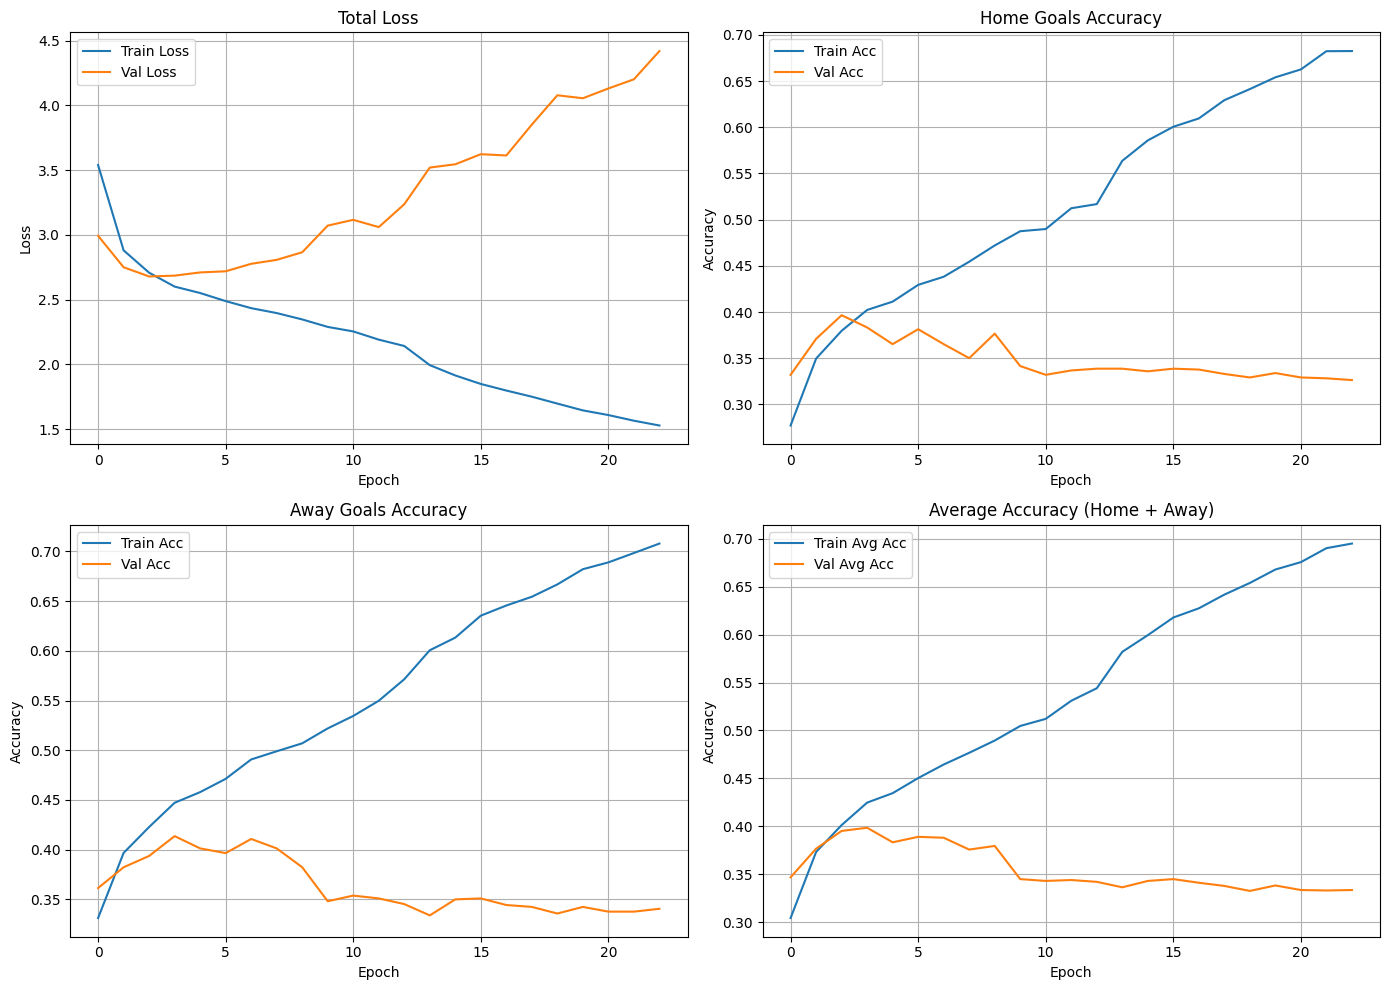

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Home accuracy
axes[0, 1].plot(history.history['home_goals_accuracy'], label='Train Acc')
axes[0, 1].plot(history.history['val_home_goals_accuracy'], label='Val Acc')
axes[0, 1].set_title('Home Goals Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Away accuracy
axes[1, 0].plot(history.history['away_goals_accuracy'], label='Train Acc')
axes[1, 0].plot(history.history['val_away_goals_accuracy'], label='Val Acc')
axes[1, 0].set_title('Away Goals Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Combined accuracy
home_acc = np.array(history.history['home_goals_accuracy'])
away_acc = np.array(history.history['away_goals_accuracy'])
combined_acc = (home_acc + away_acc) / 2

val_home_acc = np.array(history.history['val_home_goals_accuracy'])
val_away_acc = np.array(history.history['val_away_goals_accuracy'])
val_combined_acc = (val_home_acc + val_away_acc) / 2

axes[1, 1].plot(combined_acc, label='Train Avg Acc')
axes[1, 1].plot(val_combined_acc, label='Val Avg Acc')
axes[1, 1].set_title('Average Accuracy (Home + Away)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

## 12. Evaluate Model on Test Set

In [ ]:
print(f"\n{'='*60}")
print("MODEL EVALUATION ON TEST SET")
print(f"{'='*60}\n")

# Predict
predictions = model.predict(X_val_scaled, verbose=0)
pred_home_probs = predictions[0]
pred_away_probs = predictions[1]

# Get predicted classes (argmax of probability distribution)
pred_home_goals = np.argmax(pred_home_probs, axis=1)
pred_away_goals = np.argmax(pred_away_probs, axis=1)

# Get actual classes
actual_home_goals = np.argmax(y_home_test, axis=1)
actual_away_goals = np.argmax(y_away_test, axis=1)

# Calculate accuracies
home_accuracy = accuracy_score(actual_home_goals, pred_home_goals)
away_accuracy = accuracy_score(actual_away_goals, pred_away_goals)

# Exact match (both home and away correct)
exact_match = np.mean((pred_home_goals == actual_home_goals) &
                      (pred_away_goals == actual_away_goals))

# MAE (treating as regression for comparison)
mae_home = np.mean(np.abs(pred_home_goals - actual_home_goals))
mae_away = np.mean(np.abs(pred_away_goals - actual_away_goals))
mae_avg = (mae_home + mae_away) / 2

print(f"Home Goals Accuracy: {home_accuracy*100:.2f}%")
print(f"Away Goals Accuracy: {away_accuracy*100:.2f}%")
print(f"Average Accuracy: {(home_accuracy + away_accuracy)/2*100:.2f}%")
print(f"\nExact Match Accuracy: {exact_match*100:.2f}%")
print(f"  (Both home and away goals correct)")

print(f"\nMean Absolute Error:")
print(f"  Home Goals: {mae_home:.3f}")
print(f"  Away Goals: {mae_away:.3f}")
print(f"  Average: {mae_avg:.3f}")

print(f"\n{'='*60}")
print("Prediction Distribution")
print(f"{'='*60}")
print(f"\nPredicted Home Goals: {np.bincount(pred_home_goals)}")
print(f"Actual Home Goals:    {np.bincount(actual_home_goals)}")
print(f"\nPredicted Away Goals: {np.bincount(pred_away_goals)}")
print(f"Actual Away Goals:    {np.bincount(actual_away_goals)}")


MODEL EVALUATION ON TEST SET

Home Goals Accuracy: 39.66%
Away Goals Accuracy: 39.37%
Average Accuracy: 39.52%

Exact Match Accuracy: 16.41%
  (Both home and away goals correct)

Mean Absolute Error:
  Home Goals: 0.797
  Away Goals: 0.766
  Average: 0.781

Prediction Distribution

Predicted Home Goals: [212 460 295  81   2   4]
Actual Home Goals:    [259 343 235 126  59  24   7   0   1]

Predicted Away Goals: [213 651 161   6  23]
Actual Away Goals:    [320 353 224 113  32   9   2   0   0   1]


## 13. Save Model and Preprocessing 

In [ ]:
print(f"\n{'='*60}")
print("SAVING MODEL AND PREPROCESSING")
print(f"{'='*60}\n")

# Create directory
os.makedirs('trained_model', exist_ok=True)

# Save model (use .keras format)
model.save('trained_model/football_predictor.keras')
print(" Model saved: trained_model/football_predictor.keras")

# Save scaler
import joblib
joblib.dump(scaler, 'trained_model/scaler.pkl')
print("Scaler saved: trained_model/scaler.pkl")

# Save feature columns
with open('trained_model/feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
print(" Feature columns saved: trained_model/feature_columns.pkl")

# Save configuration
config = {
    'max_goals': MAX_GOALS,
    'num_classes': NUM_CLASSES,
    'num_features': len(feature_cols),
    'train_samples': len(X_train),
    'test_accuracy_home': float(home_accuracy),
    'test_accuracy_away': float(away_accuracy),
    'exact_match_accuracy': float(exact_match),
    'mae_average': float(mae_avg)
}

with open('trained_model/config.pkl', 'wb') as f:
    pickle.dump(config, f)
print(" Configuration saved: trained_model/config.pkl")

print(f"\n{'='*60}")
print(" ALL FILES SAVED SUCCESSFULLY!")
print(f"{'='*60}")
print(f"\nSaved files:")
print(f"  • football_predictor.keras (model)")
print(f"  • scaler.pkl (feature scaling)")
print(f"  • feature_columns.pkl (column order)")
print(f"  • config.pkl (model configuration)")


SAVING MODEL AND PREPROCESSING

✅ Model saved: trained_model/football_predictor.keras
✅ Scaler saved: trained_model/scaler.pkl
✅ Feature columns saved: trained_model/feature_columns.pkl
✅ Configuration saved: trained_model/config.pkl

✅ ALL FILES SAVED SUCCESSFULLY!

Saved files:
  • football_predictor.keras (model)
  • scaler.pkl (feature scaling)
  • feature_columns.pkl (column order)
  • config.pkl (model configuration)


## 14. Load Saved Model 

In [ ]:
import joblib

print(f"\n{'='*60}")
print("LOADING SAVED MODEL")
print(f"{'='*60}\n")

# Load model
loaded_model = keras.models.load_model('trained_model/football_predictor.keras')
print(" Model loaded")

# Load scaler
loaded_scaler = joblib.load('trained_model/scaler.pkl')
print(" Scaler loaded")

# Load feature columns
with open('trained_model/feature_columns.pkl', 'rb') as f:
    loaded_feature_cols = pickle.load(f)
print(" Feature columns loaded")

# Load config
with open('trained_model/config.pkl', 'rb') as f:
    loaded_config = pickle.load(f)
print(" Configuration loaded")

print(f"\nModel Configuration:")
print(f"  Max goals: {loaded_config['max_goals']}")
print(f"  Features: {loaded_config['num_features']}")
print(f"  Test accuracy: {loaded_config['test_accuracy_home']*100:.2f}% (home), "
      f"{loaded_config['test_accuracy_away']*100:.2f}% (away)")
print(f"  Exact match: {loaded_config['exact_match_accuracy']*100:.2f}%")


LOADING SAVED MODEL

✅ Model loaded
✅ Scaler loaded
✅ Feature columns loaded
✅ Configuration loaded

Model Configuration:
  Max goals: 9
  Features: 700
  Test accuracy: 40.23% (home), 42.31% (away)
  Exact match: 17.08%


## 15. Prediction Functions

In [ ]:
from process_football_data import load_standings, get_team_ranking, calculate_form_score

standings_cache = load_standings()


def _select_top_minutes_players(df_team):
    """Select top 15 outfield players and top keeper by total minutes in the season."""
    outfield_minutes, outfield_sample = {}, {}
    gk_minutes, gk_sample = {}, {}

    for _, row in df_team.iterrows():
        for player in parse_player_data(row['outfield_players']):
            name = player.get(('player', ''), '') or player.get('player', '')
            if not name:
                continue
            mins = player.get(('min', ''), 0) or player.get('min', 0)
            try:
                mins = float(mins)
            except Exception:
                mins = 0.0
            outfield_minutes[name] = outfield_minutes.get(name, 0) + mins
            outfield_sample[name] = player

        for gk in parse_player_data(row['keepers']):
            name = gk.get(('player', ''), '') or gk.get('player', '')
            if not name:
                continue
            mins = gk.get(('min', ''), 0) or gk.get('min', 0)
            try:
                mins = float(mins)
            except Exception:
                mins = 0.0
            gk_minutes[name] = gk_minutes.get(name, 0) + mins
            gk_sample[name] = gk

    sorted_outfield = sorted(outfield_minutes.items(), key=lambda x: x[1], reverse=True)
    outfield_players = [outfield_sample[name] for name, _ in sorted_outfield[:15]]

    sorted_gk = sorted(gk_minutes.items(), key=lambda x: x[1], reverse=True)
    keepers = [gk_sample[name] for name, _ in sorted_gk[:1]]

    return outfield_players, keepers


def _compute_team_rollups(team, league, season, games, opponent_rankings):
    """Recompute rolling team metrics the same way as process_football_data.py."""
    if len(games) == 0:
        return {
            'last_games_str': '',
            'avg_goals_for_last5': 0.0,
            'avg_goals_against_last5': 0.0,
            'avg_points_last5': 0.0,
            'recent_form_score_last5': 0.0,
        }

    last5 = games.tail(5)
    game_strs = []
    total_gf = total_ga = total_points = 0

    for _, game in last5.iterrows():
        game_str = f"{game['team']} {game['goals_for']} {game['goals_against']} {game['opponent']}"
        game_strs.append(game_str)
        total_gf += game['goals_for']
        total_ga += game['goals_against']
        if game['goals_for'] > game['goals_against']:
            total_points += 3
        elif game['goals_for'] == game['goals_against']:
            total_points += 1

    last_games_str = ', '.join(game_strs)
    avg_points = total_points / len(last5)

    team_ranking = get_team_ranking(team, league, season, standings_cache)
    form_score = calculate_form_score(last_games_str, team, opponent_rankings, team_ranking)

    return {
        'last_games_str': last_games_str,
        'avg_goals_for_last5': total_gf / len(last5),
        'avg_goals_against_last5': total_ga / len(last5),
        'avg_points_last5': avg_points,
        'recent_form_score_last5': form_score,
    }


def _build_opponent_rankings(df_season, league, season):
    key = f"{league}_{season}"
    rankings = {}
    if key in standings_cache:
        for team_name in df_season['team'].unique():
            rank = get_team_ranking(team_name, league, season, standings_cache)
            if rank:
                rankings[team_name] = rank
    return rankings


def predict_match(home_team, away_team, df_original, model, scaler, feature_cols,
                 league='ENG-Premier League', season=2526, target_date=None,
                 show_probabilities=False):
    """Predict a match using the trained model with the same feature pipeline as training."""
    print(f"{'='*60}")
    print(f"MATCH PREDICTION: {home_team} vs {away_team}")
    print(f"League: {league}, Season: {season}")
    print(f"{'='*60}")

    df_original = df_original.copy()
    df_original['date'] = pd.to_datetime(df_original['date'])

    df_season = df_original[(df_original['league'] == league) & (df_original['season'] == season)].copy()
    if len(df_season) == 0:
        print(f" Error: No data for {league} season {season}")
        return

    df_season = df_season.sort_values(['date', 'match_id'])
    if target_date is None:
        target_date = df_season['date'].max() + pd.Timedelta(days=7)
    target_date = pd.to_datetime(target_date)

    player_history, gk_history = {}, {}

    # Build histories from all prior matches in this season
    for match_id, match_rows in df_season[df_season['date'] < target_date].groupby('match_id'):
        home_rows = match_rows[match_rows['is_home'] == 1]
        away_rows = match_rows[match_rows['is_home'] == 0]
        if len(home_rows) == 0 or len(away_rows) == 0:
            continue
        home_row = home_rows.iloc[0]
        away_row = away_rows.iloc[0]

        home_data = process_match_rolling(home_row, player_history, gk_history)
        away_data = process_match_rolling(away_row, player_history, gk_history)

        update_player_history(home_row, player_history, gk_history)
        update_player_history(away_row, player_history, gk_history)

    opponent_rankings = _build_opponent_rankings(df_season, league, season)

    def build_synthetic_row(team, is_home_flag):
        team_games = df_season[df_season['team'] == team]
        games_before = team_games[team_games['date'] < target_date]
        base_games = games_before if len(games_before) > 0 else team_games

        outfield_players, keepers = _select_top_minutes_players(base_games)

        rollups = _compute_team_rollups(team, league, season, base_games, opponent_rankings)

        avg_xg_for = base_games['xg_for'].mean() if len(base_games) > 0 else 0.0
        avg_xg_against = base_games['xg_against'].mean() if len(base_games) > 0 else 0.0
        club_ranking = get_team_ranking(team, league, season, standings_cache)

        return {
            'team': team,
            'league': league,
            'season': season,
            'date': target_date,
            'is_home': is_home_flag,
            'xg_for': avg_xg_for if pd.notna(avg_xg_for) else 0.0,
            'xg_against': avg_xg_against if pd.notna(avg_xg_against) else 0.0,
            'avg_goals_for_last5': rollups['avg_goals_for_last5'],
            'avg_goals_against_last5': rollups['avg_goals_against_last5'],
            'avg_points_last5': rollups['avg_points_last5'],
            'recent_form_score_last5': rollups['recent_form_score_last5'],
            'club_ranking': club_ranking if club_ranking is not None else 10,
            'outfield_players': str(outfield_players),
            'keepers': str(keepers),
            # Placeholder goals for compatibility; not used for inference targets
            'goals_for': 0,
        }

    home_row = build_synthetic_row(home_team, 1)
    away_row = build_synthetic_row(away_team, 0)

    home_data = process_match_rolling(home_row, player_history, gk_history)
    away_data = process_match_rolling(away_row, player_history, gk_history)

    features, _ = create_match_level_features(home_data, away_data)

    X_array = np.array([[features.get(col, 0) for col in feature_cols]])
    X_array = np.nan_to_num(X_array, nan=0.0)
    X_scaled = scaler.transform(X_array)

    predictions = model.predict(X_scaled, verbose=0)
    home_probs = predictions[0][0]
    away_probs = predictions[1][0]

    pred_home = int(np.argmax(home_probs))
    pred_away = int(np.argmax(away_probs))

    print(f" PREDICTED SCORE: {home_team} {pred_home} - {pred_away} {away_team}")
    print(f"Confidence:")
    print(f"  {home_team}: {home_probs[pred_home]*100:.1f}% for {pred_home} goals")
    print(f"  {away_team}: {away_probs[pred_away]*100:.1f}% for {pred_away} goals")

    if show_probabilities:
        print(f"Probability Distributions:")
        print(f"{home_team} Goals:")
        for i, prob in enumerate(home_probs[:6]):
            if not np.isnan(prob):
                bar = '█' * int(prob * 50)
                print(f"  {i} goals: {bar} {prob*100:.1f}%")

        print(f"{away_team} Goals:")
        for i, prob in enumerate(away_probs[:6]):
            if not np.isnan(prob):
                bar = '█' * int(prob * 50)
                print(f"  {i} goals: {bar} {prob*100:.1f}%")

print("✅ Prediction function updated")



✅ Prediction function updated


## 16. Make Predictions 

### Load Original Data

In [10]:
# Load original data for feature extraction
df_original = pd.read_csv("processed_football_data.csv", engine='python', encoding='utf-8')
df_original['date'] = pd.to_datetime(df_original['date'])

print("✅ Original data loaded")

✅ Original data loaded


In [17]:
# Example 1: Arsenal vs Liverpool
predict_match(
    'Crystal Palace',
    'Manchester City',
    df_original,
    loaded_model,
    loaded_scaler,
    loaded_feature_cols,
    show_probabilities=True
)

MATCH PREDICTION: Crystal Palace vs Manchester City
League: ENG-Premier League, Season: 2526


🎯 PREDICTED SCORE: Crystal Palace 2 - 1 Manchester City
Confidence:
  Crystal Palace: 41.5% for 2 goals
  Manchester City: 34.4% for 1 goals
Probability Distributions:
Crystal Palace Goals:
  0 goals: ██ 4.1%
  1 goals: ██████████████ 29.5%
  2 goals: ████████████████████ 41.5%
  3 goals: ██████████ 21.2%
  4 goals: █ 3.4%
  5 goals:  0.2%
Manchester City Goals:
  0 goals: █████ 11.7%
  1 goals: █████████████████ 34.4%
  2 goals: ███████████████ 30.5%
  3 goals: ███████ 15.5%
  4 goals: ███ 6.9%
  5 goals:  0.6%
